

# Dataset

Trimmed [Credit risk dataset](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) to have only:

<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text - little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in month)<br>
<b>Purpose</b>(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others<br>
<b>Risk </b> (Value target - Good or Bad Risk)<br>

See [german-credit-data-with-risk](https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk) to see the data in Kaggle.


# Note
Install OpenMP runtime on Macbook.
```
brew install libomp
```


# Setup

In [14]:
import json
import warnings

import numpy as np
import pandas as pd

# Show full arrays without truncation
pd.set_option('display.max_colwidth', None)   # Prevent shortening of column values
pd.set_option('display.max_seq_items', None)  # Prevent truncation of sequences
pd.set_option('display.expand_frame_repr', False)  # Keep everything in one line per column

In [2]:
%load_ext autoreload
%autoreload 2

from eda import (
    analyse_target_distribution,
    analyse_per_generation,
    analyse_per_property,
    analyse_per_gender,
    analyse_risk_per_saving,
    risk_per_generation,
    risk_per_credit_amount_bin,
    risk_heatmap,
    risk_correlation,
)

from evaluation import (
    evaluate_model
)

from psql import (
    batch_insert_with_progress,
)

# Data


In [3]:
df = pd.read_csv(
    "../data/raw/german_credit_data.csv",
    index_col=0,
    converters={'Risk': lambda x: {'good': 0., 'bad': 1.}[x]}
)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0.0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1.0
2,49,male,1,own,little,NaN,2096,12,education,0.0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0.0
4,53,male,2,free,little,little,4870,24,car,1.0


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   object 
 2   Job               1000 non-null   int64  
 3   Housing           1000 non-null   object 
 4   Saving accounts   817 non-null    object 
 5   Checking account  606 non-null    object 
 6   Credit amount     1000 non-null   int64  
 7   Duration          1000 non-null   int64  
 8   Purpose           1000 non-null   object 
 9   Risk              1000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 85.9+ KB
None


### Column Types

In [5]:
numeric_cols = ['Age', 'Credit amount', 'Duration']
categorical_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

### Unique Categorical Values

In [6]:
max_len = max(len(col) for col in categorical_cols)

for col in categorical_cols:
    # Convert unique values to string and join them with commas
    unique_values = df[col].dropna().unique()  # optional: remove NaN
    unique_str = ', '.join(str(val) for val in unique_values)
    print(f"{col:<{max_len}} : [{unique_str}]")

Sex              : [male, female]
Job              : [2, 1, 3, 0]
Housing          : [own, free, rent]
Saving accounts  : [little, quite rich, rich, moderate]
Checking account : [little, moderate, rich]
Purpose          : [radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others]


# EDA

## Target label (Risk) and imbalance


In [7]:
analyse_target_distribution(df=df)
scale = sum(df['Risk'] == False) / sum(df['Risk'] == True)
scale

2.3333333333333335

## Risk by Credit Amount

Higher the amount, higher the risk.


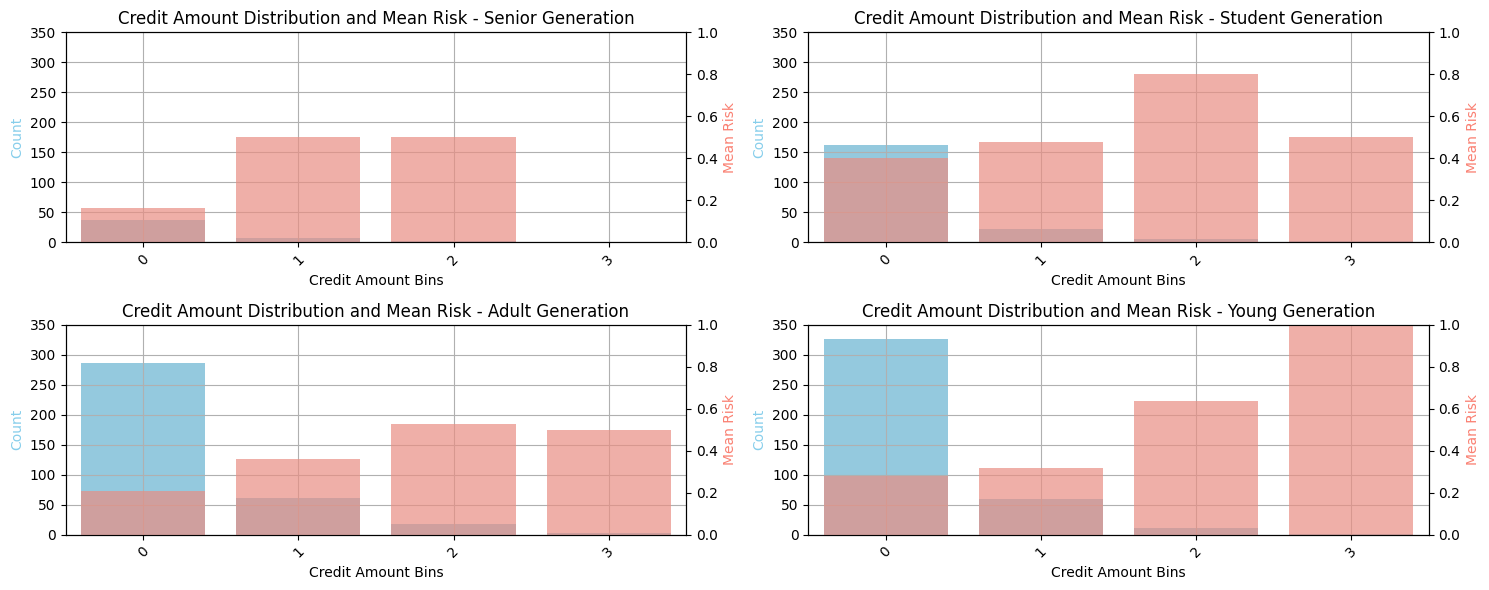

In [8]:
analyse_per_generation(df)
risk_per_credit_amount_bin(df)

if "Generation" not in categorical_cols: categorical_cols += ["Generation"]
if 'Age' in numeric_cols: numeric_cols.remove('Age')

if "Amount" not in categorical_cols: categorical_cols += ["Amount"]
if 'Credit amount' in numeric_cols: numeric_cols.remove('Credit amount')

# Risk Correlation

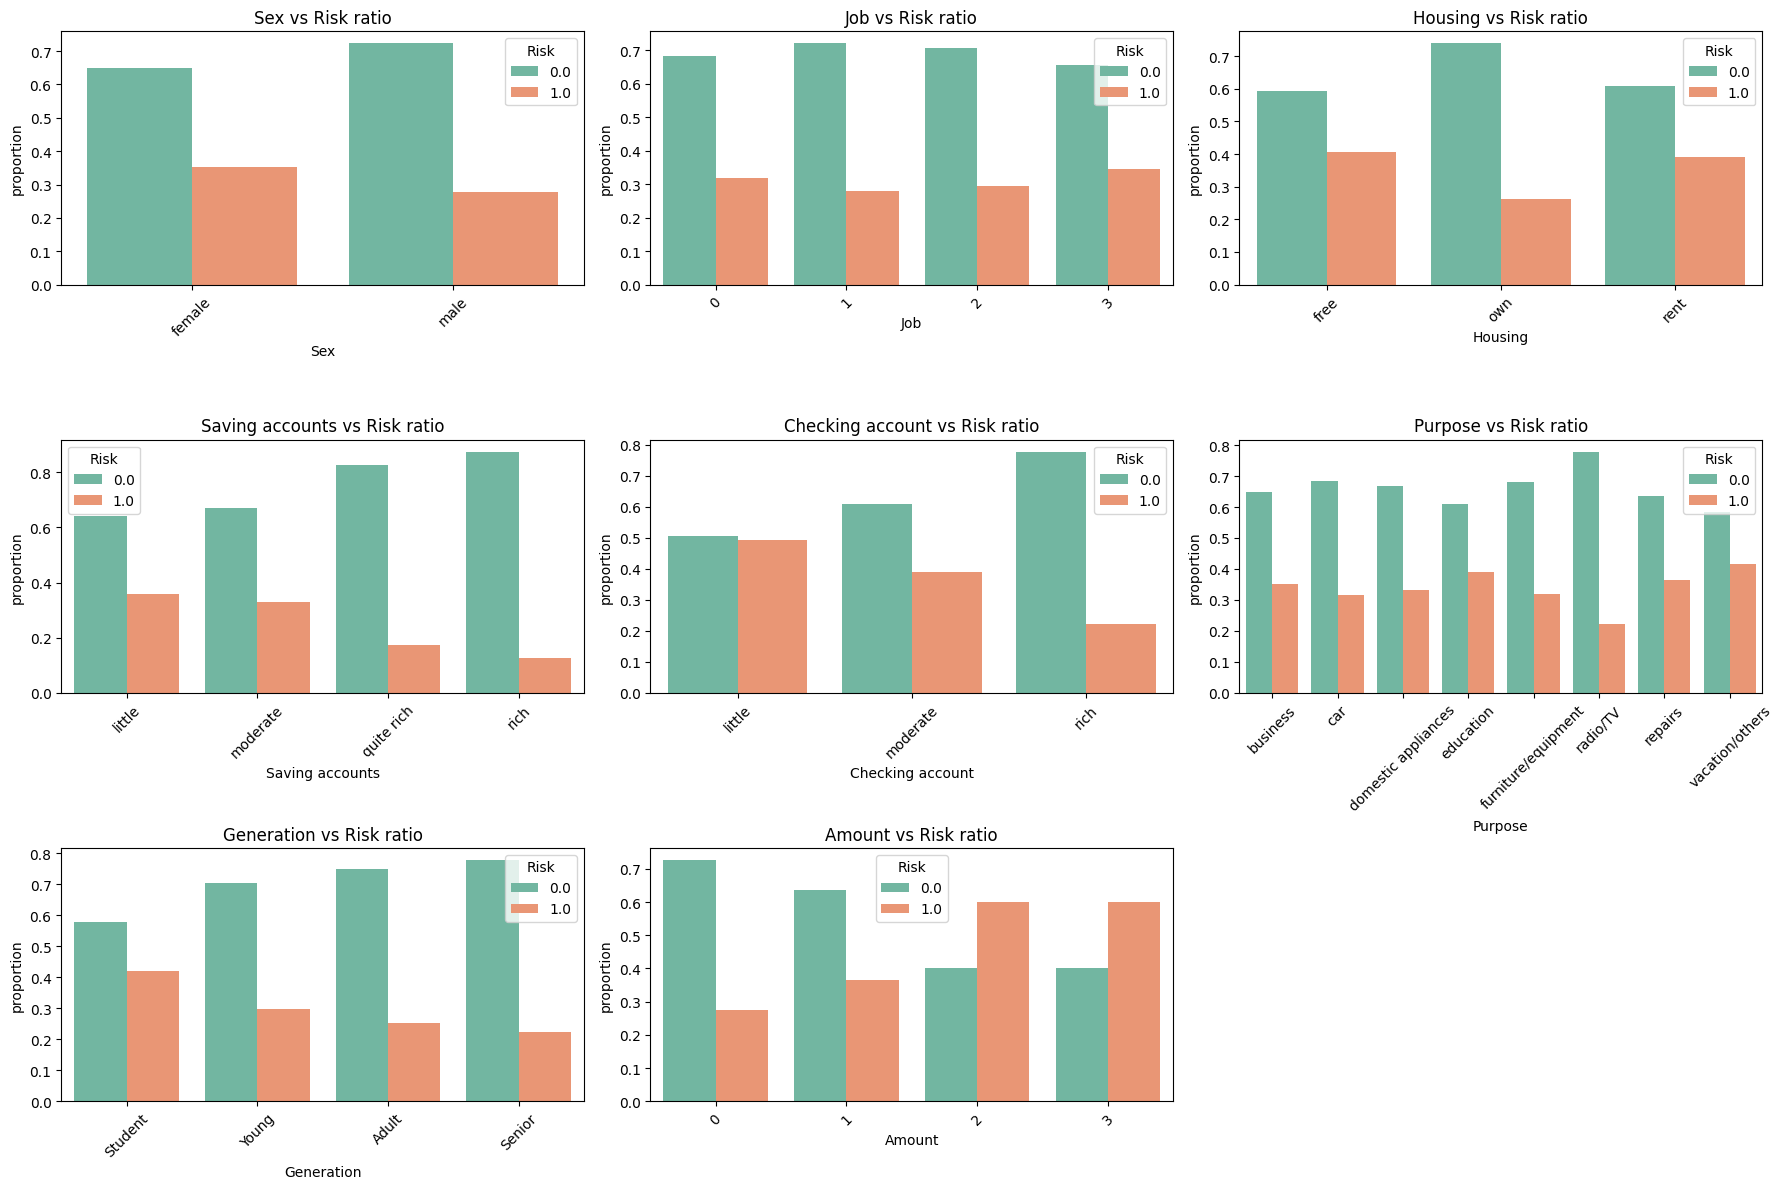

In [9]:
risk_correlation(df, categorical_cols)

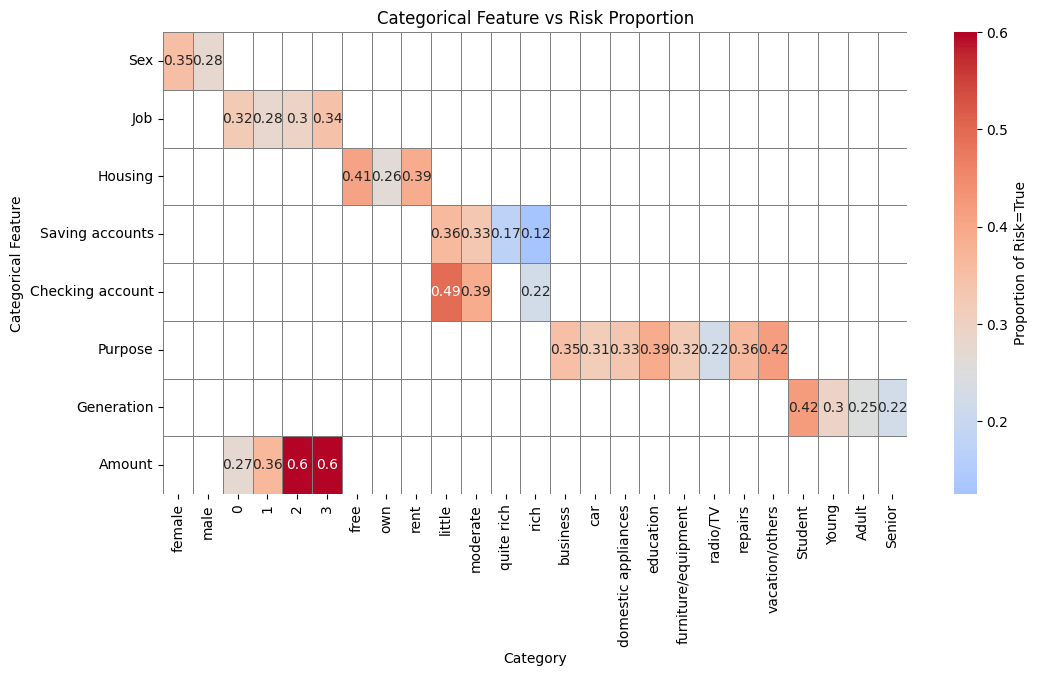

In [10]:
risk_heatmap(df, categorical_cols)

---

# Featur Engineering

In [11]:
df_train = df[numeric_cols + categorical_cols]
# df_train.head()

### Imputation of missing values

In [12]:
df_train['Saving accounts'] = df_train['Saving accounts'].fillna('no_inf')
df_train['Checking account'] = df_train['Checking account'].fillna('no_inf')

### Categorical to One Hot Encoding

In [15]:
df_train = df_train.merge(pd.get_dummies(df_train.Purpose, drop_first=False, prefix='purpose', dtype=np.float32), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train.Sex, drop_first=False, prefix='gender', dtype=np.float32), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train.Housing, drop_first=False, prefix='property', dtype=np.float32), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train["Saving accounts"], drop_first=False, prefix='savings', dtype=np.float32), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train["Checking account"], drop_first=False, prefix='check', dtype=np.float32), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train["Generation"], drop_first=False, prefix='generation', dtype=np.float32), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train["Job"], drop_first=False, prefix='job', dtype=np.float32), left_index=True, right_index=True)
df_train = df_train.merge(pd.get_dummies(df_train["Amount"], drop_first=False, prefix='amount', dtype=np.float32), left_index=True, right_index=True)

### Drop unused columns

In [16]:
del df_train["Saving accounts"]
del df_train["Checking account"]
del df_train["Purpose"]
del df_train["Sex"]
del df_train["Housing"]
del df_train["Job"]
del df_train["Duration"]
del df_train["Generation"]
del df_train['Amount']

# Features for Model Consumption

Verify the features to be consumed by the Model Training

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   purpose_business             1000 non-null   float32
 1   purpose_car                  1000 non-null   float32
 2   purpose_domestic appliances  1000 non-null   float32
 3   purpose_education            1000 non-null   float32
 4   purpose_furniture/equipment  1000 non-null   float32
 5   purpose_radio/TV             1000 non-null   float32
 6   purpose_repairs              1000 non-null   float32
 7   purpose_vacation/others      1000 non-null   float32
 8   gender_female                1000 non-null   float32
 9   gender_male                  1000 non-null   float32
 10  property_free                1000 non-null   float32
 11  property_own                 1000 non-null   float32
 12  property_rent                1000 non-null   float32
 13  savings_little          

In [18]:
df_train.head()

,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others,gender_female,gender_male,...,generation_Adult,generation_Senior,job_0,job_1,job_2,job_3,amount_0,amount_1,amount_2,amount_3
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# Save the created Features as CSV

Not using Parquet for human readability.

In [19]:
df_train.to_csv('../data/processed/credit_risk_features.csv', index=False)

---
